In [32]:
import re
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from structij.lwcv import LWCV
from structij.models.hidden_markov_model import HMM
from structij.utils import genSyntheticDataset, get_indices_in_held_out_fold
path_root = '../anomaly_detection/'
sys.path.append(str(path_root))
from detectors import InfluenceFunctionDetector

In [4]:
dataset = "SMAP_MSL"
data_path = Path("../data/multivariate/") / dataset
test_df = pd.read_csv(data_path/"labeled_anomalies.csv")
smap_df = test_df.loc[test_df.spacecraft == "SMAP"]
df = smap_df.loc[smap_df.chan_id != "P-2"]

In [5]:
class Config:
    def __init__(self):
        self.win_size = 25
        self.data_path = '../anomaly_detection/data_processed/SMAP'
        self.dimensions = [0]
        self.dataset = 'SMAP'
        self.verbose = False
        
df = smap_df.loc[smap_df.chan_id != "P-2"]
config = Config()
detector = InfluenceFunctionDetector(config)

anomaly ratio is 8.795 %.
start detection for channel P-1 ..
Performing initial model fit!
Performing ACV


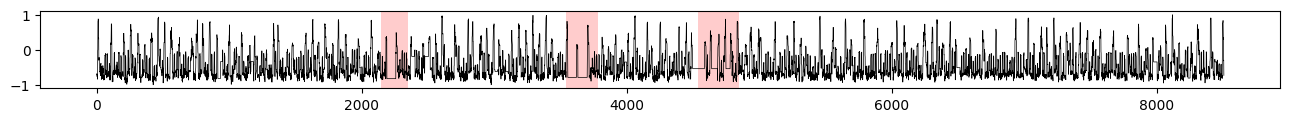

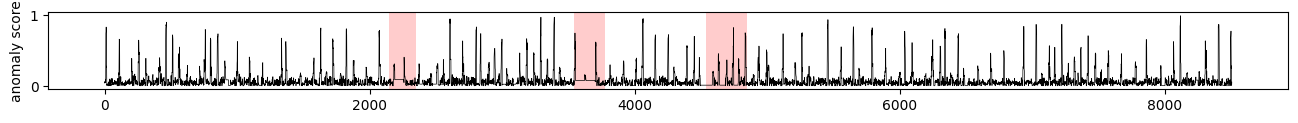

Threshold:0.21
Precision: 0.08 Recall: 0.08 F1: 0.08 AUC: 0.54


In [33]:
len_test_dict, len_anomaly_dict, len_ratio_dict = {}, {}, {}
prec_dict, rec_dict, f1_dict, auc_dict = {}, {}, {}, {}
time_dict = {}

for channel in df.chan_id.iloc:

    if config.dimensions is not None:
        ts_test = np.load(data_path/"test"/f"{channel}.npy")[:,config.dimensions]
    else:
        ts_test = np.load(data_path/"test"/f"{channel}.npy")

    seq_len = len(ts_test)
    anomaly_seqs = df.loc[df.chan_id == channel].anomaly_sequences.to_numpy().item()
    anomaly_seqs = re.findall(r'\d+', anomaly_seqs)
    anomaly_intervals = []
    for i in list(range(0, len(anomaly_seqs), 2)):
        anomaly_intervals.append(anomaly_seqs[i:i+2])
    anomaly_intervals = np.array(anomaly_intervals).astype(int)

    ground_truth = np.zeros(ts_test.shape[0])
    plt.figure(figsize=(16,1))
    plt.plot(ts_test, c="k", linewidth=.5)
    for anomaly_points in anomaly_intervals:
        plt.axvspan(anomaly_points[0], anomaly_points[-1], facecolor='red', alpha=.2)
        ground_truth[anomaly_points[0]:anomaly_points[-1]] = 1.

    anomaly_len = sum(ground_truth)
    anomaly_ratio = anomaly_len / seq_len
    print(f"anomaly ratio is {anomaly_ratio * 100.:.3f} %.")

    len_test_dict.update({channel: seq_len})
    len_anomaly_dict.update({channel: anomaly_len})
    len_ratio_dict.update({channel: anomaly_ratio})

    print(f"start detection for channel {channel} ..")
    start_time = time.time()

    D = 1 # data dimension
    K = 2 # number of HMM states
    T = seq_len # Length of sequence

    X = ts_test.reshape(1,-1,1)
    config_dict = {'K': K, 'precision': None}
    model = HMM(X, config_dict)
    weights_one = np.ones([T])
    # MAP fit
    print ("Performing initial model fit!")
    opt_params = model.fit(weights_one, init_params=None, num_random_restarts=1,  maxiter=None)
    theta_one = opt_params.copy()
    o = list(range(seq_len))
    lwcv = LWCV(model, theta_one, T, o)
    print ("Performing ACV")
    params_acv = lwcv.compute_params_acv()
    weights = np.ones([T])
    weights[o] = 0
    approx_cv_loss = model.loss_at_missing_timesteps(weights, params=params_acv)
        
    end_time = time.time()
    elapsed_time = round(end_time - start_time, 3)

    plt.figure(figsize=(16,1))
    loos_viz = approx_cv_loss
    plt.plot(loos_viz, c="k", linewidth=.5)
    for anomaly_points in anomaly_intervals:
        plt.axvspan(anomaly_points[0], anomaly_points[-1], facecolor='red', alpha=.2)
        ground_truth[anomaly_points[0]:anomaly_points[-1]] = 1.
    plt.ylabel("anomaly score")
    plt.show()

    prec, rec, f1, auc = detector.evaluate(ground_truth, approx_cv_loss, anomaly_ratio)

    prec_dict.update({channel: prec})
    rec_dict.update({channel: rec})
    f1_dict.update({channel: f1})
    auc_dict.update({channel: auc})
    time_dict.update({channel: elapsed_time})
    
    break

smap_metrics = pd.DataFrame({
    "Num_of_Test": len_test_dict,
    "Len_of_Anomaly": len_anomaly_dict,
    "Anomaly_Ratio": len_ratio_dict,
    "Precision": prec_dict,
    "Recall": rec_dict,
    "F1": f1_dict,
    "AUC": auc_dict,
    'Detection_Time(s)': time_dict
})

smap_metrics.insert(0, "Dataset", smap_metrics.index)
smap_metrics.reset_index(drop = True, inplace = True)